In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
plt.style.use('fivethirtyeight')

In [2]:
sales = pd.read_csv('cardox.csv')
sales.index = pd.to_datetime(sales.date, format='%Y-%m-%d')
sales.drop('date', axis=1, inplace=True)
sales.head(5)

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86


In [3]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 1958-03-01 to 2018-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   729 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


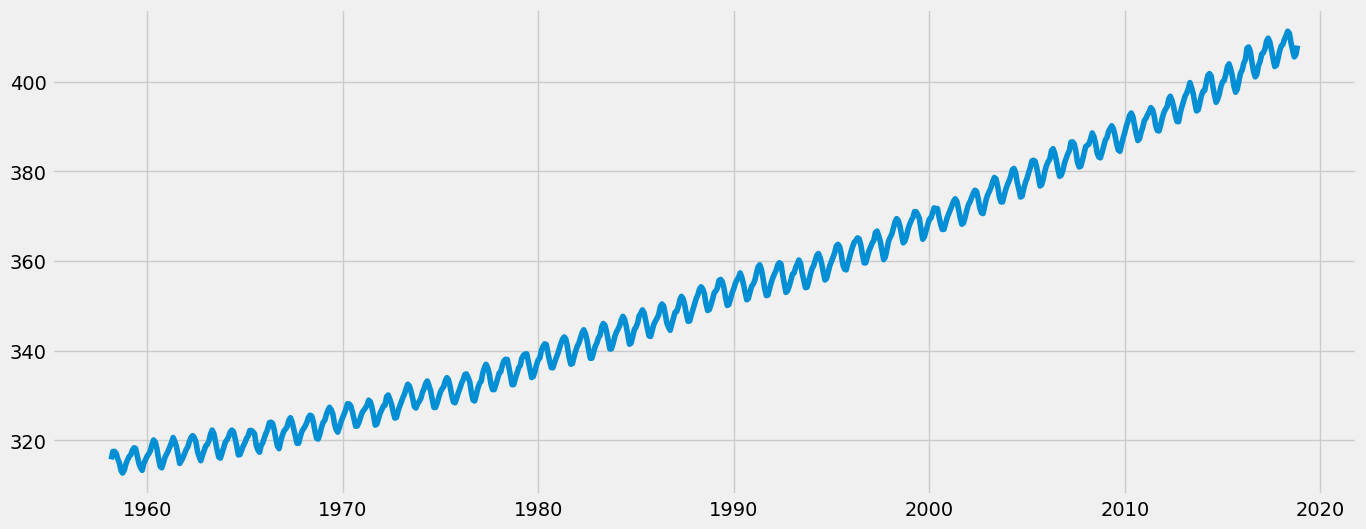

In [4]:
plt.figure(figsize=(15, 6))
plt.plot(sales)

Text(0.5, 0.98, 'Мультиплікативна модель')

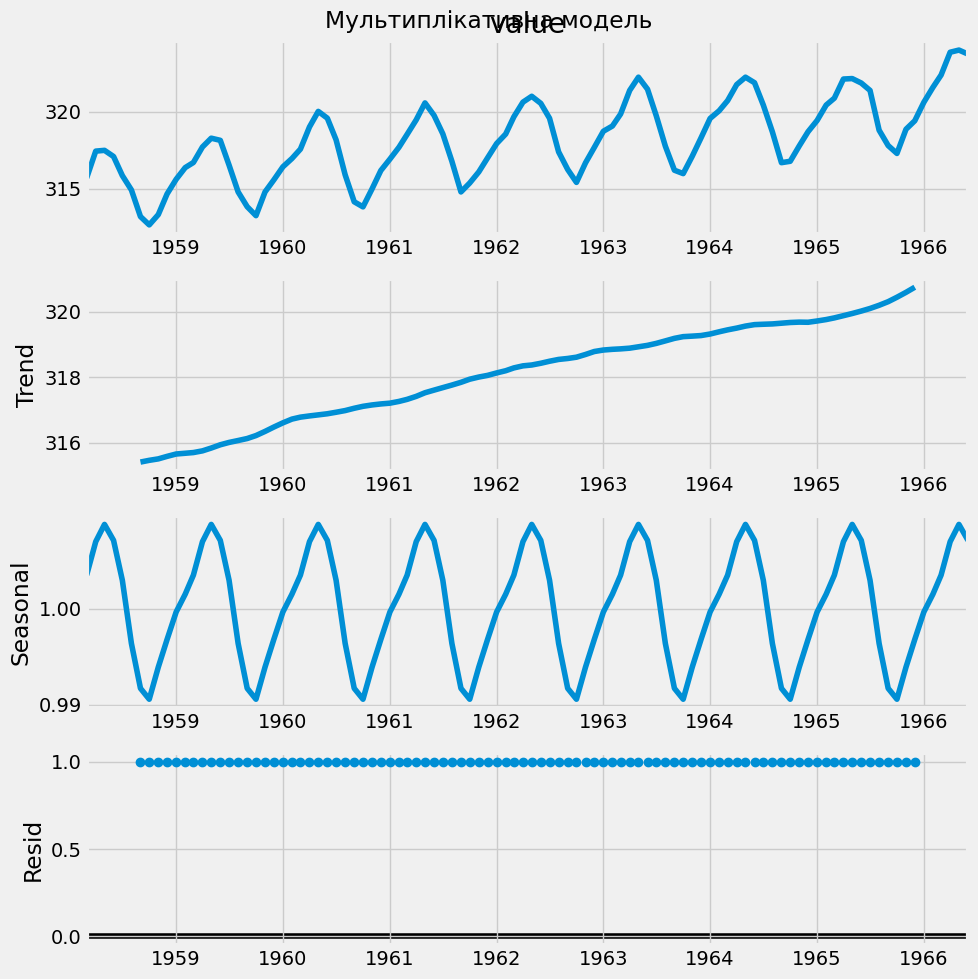

In [5]:
decomposed = seasonal_decompose(sales.value[0:100], model='multiplicative')
plt.rcParams.update({'figure.figsize': (10,10)})
decomposed.plot().suptitle('Мультиплікативна модель')

In [6]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(sales, autolag='AIC')
print(f'ADF-статистика: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Критичні значення:')
    print(f'   {key}, {value}')

ADF-статистика: 4.994847244403925
p-value: 1.0
Критичні значення:
   1%, -3.439620010600208
Критичні значення:
   5%, -2.8656309041017756
Критичні значення:
   10%, -2.5689484851894413


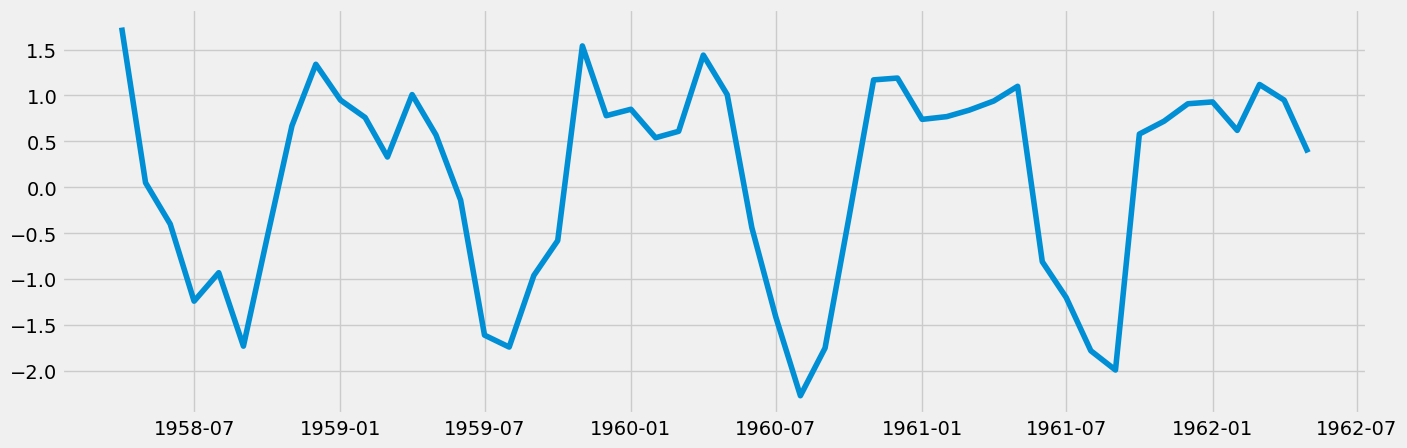

In [7]:
detrended = sales.diff()[1:]
plt.figure(figsize=(15, 5))
plt.plot(detrended[0:50])

D:\python_projects\python_3_10_9\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


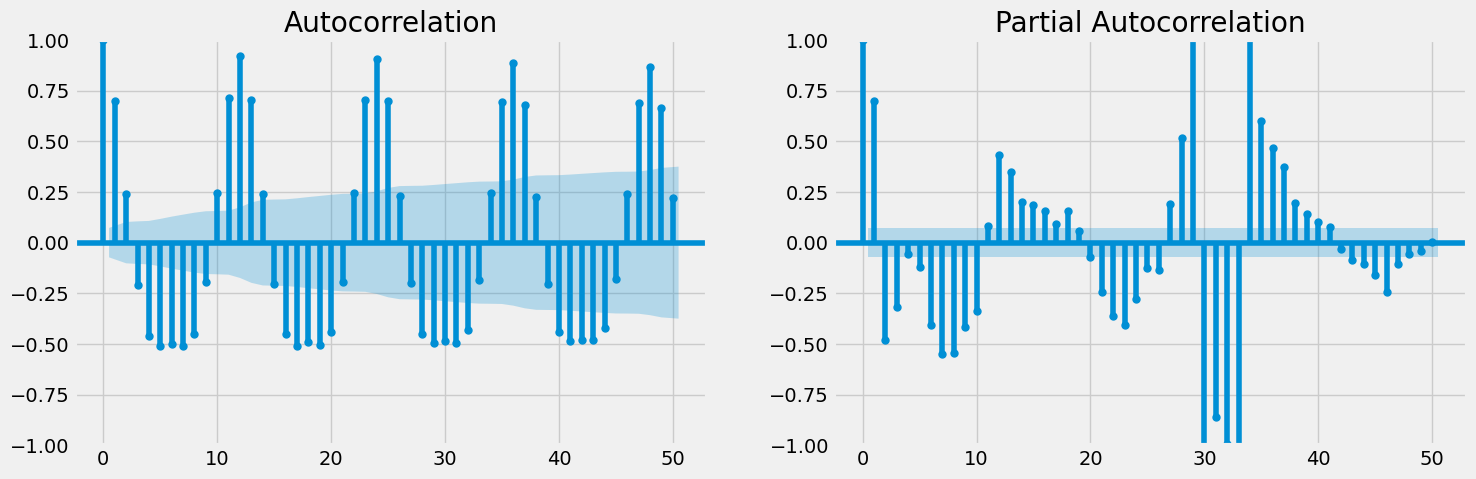

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,2,figsize=(16,5), dpi= 100)
plot_acf(detrended, lags=50, ax=axes[0])
plot_pacf(detrended, lags=50, ax=axes[1])
plt.show()

### Для прогнозування скористаємось моделлю SARIMA
### Виходячи з результатів автокорреляції та частичної автокорреляції маємо сезонність з періодом 12
### Для підбору моделі з кращими параметрами по черзі будемо підберати параметри p, d, q для моделі та вираховувати AIC

In [9]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

warnings.filterwarnings("ignore")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        model = ARIMA(sales,
                      order=param,
                      seasonal_order=param_seasonal,
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit()
        print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, model.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:6896.026330835386
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:5868.510106587323
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:2822.10872847603
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:2377.959623194229
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:1558.604220754482
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1277.1292012167692
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:1864.338786334426
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:1357.4062887755395
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:5896.067901244104
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:4893.823591784154
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:2101.364214527621
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:1884.3261540896565
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:1017.6433759075585
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:980.028176101299
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:1582.5491836408755
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:1055.355918683583
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:2371.0019758047247
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1756.5111480115293
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:843.42

In [10]:

model = ARIMA(sales, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False).fit()

In [11]:

model.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.1707,0.084,2.038,0.042,0.007,0.335
ma.L1,-0.5360,0.073,-7.307,0.000,-0.680,-0.392
ar.S.L12,-0.0005,0.000,-1.624,0.104,-0.001,9.84e-05
ma.S.L12,-0.8671,0.021,-41.947,0.000,-0.908,-0.827
sigma2,0.0941,0.005,20.328,0.000,0.085,0.103


In [12]:
predictions = model.get_prediction(pd.to_datetime('2014-08-01'))
conf_int = predictions.conf_int()

Text(0, 0.5, 'Sales')

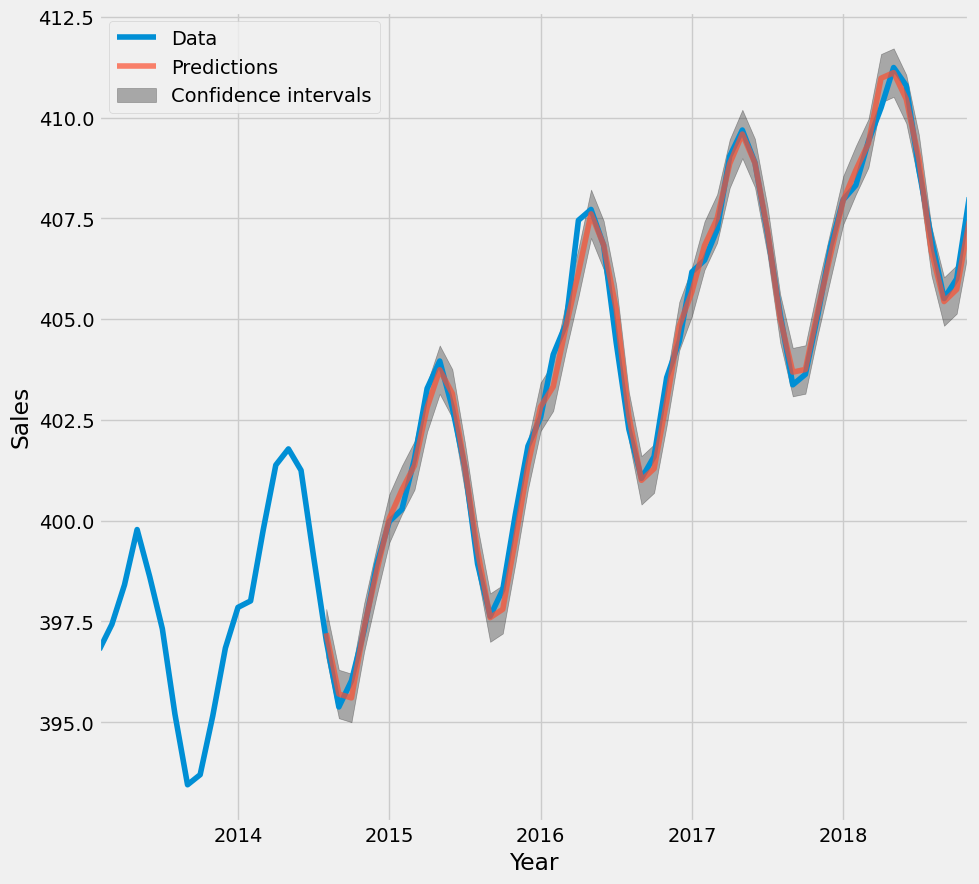

In [13]:
ax = sales[len(sales)-70:].plot()
predictions.predicted_mean.plot(alpha=.7)
ax.fill_between(conf_int.index, conf_int['lower value'], conf_int['upper value'], alpha=.3, color='k')

plt.legend(('Data', 'Predictions', 'Confidence intervals'))
ax.set_xlabel('Year')
ax.set_ylabel('Sales')

In [14]:
dynamic_predictions = model.get_prediction(pd.to_datetime('2014-08-01'), dynamic=True)
dynamic_conf_int = predictions.conf_int()

Text(0, 0.5, 'Sales')

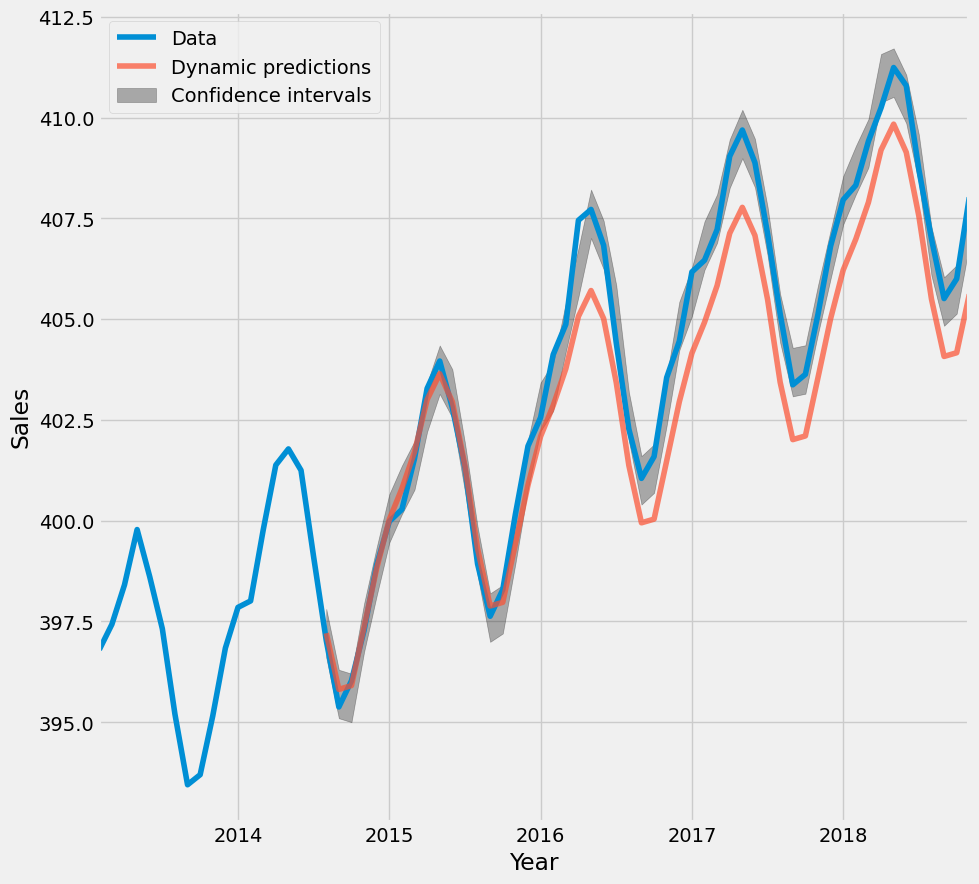

In [15]:
ax = sales[len(sales)-70:].plot()
dynamic_predictions.predicted_mean.plot(alpha=.7)
ax.fill_between(dynamic_conf_int.index, dynamic_conf_int['lower value'], dynamic_conf_int['upper value'], alpha=.3, color='k')

plt.legend(('Data', 'Dynamic predictions', 'Confidence intervals'))
ax.set_xlabel('Year')
ax.set_ylabel('Sales')

### Оскільки сезонний AR(12) має p значення 0.1, приберемо цей параметр в новій моделі та порахуємо залишки для обох моделей

In [16]:
predictions = model.get_prediction(sales.index[20])
residuals = sales.value[20:] - predictions.predicted_mean
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.31192876630654776


In [17]:
model1 = ARIMA(sales, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False).fit()

In [18]:
model1.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.1869,0.083,2.257,0.024,0.025,0.349
ma.L1,-0.5487,0.072,-7.587,0.000,-0.690,-0.407
ma.S.L12,-0.8643,0.021,-41.660,0.000,-0.905,-0.824
sigma2,0.0948,0.005,20.417,0.000,0.086,0.104


In [19]:
predictions = model1.get_prediction(sales.index[20])
residuals = sales.value[20:] - predictions.predicted_mean
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.31273963457760984


### Середній квадрат залишків/похибок майже однаковий, навіть трішки більший ніж з параметром AR(12), тому виберемо модель з цим параметром

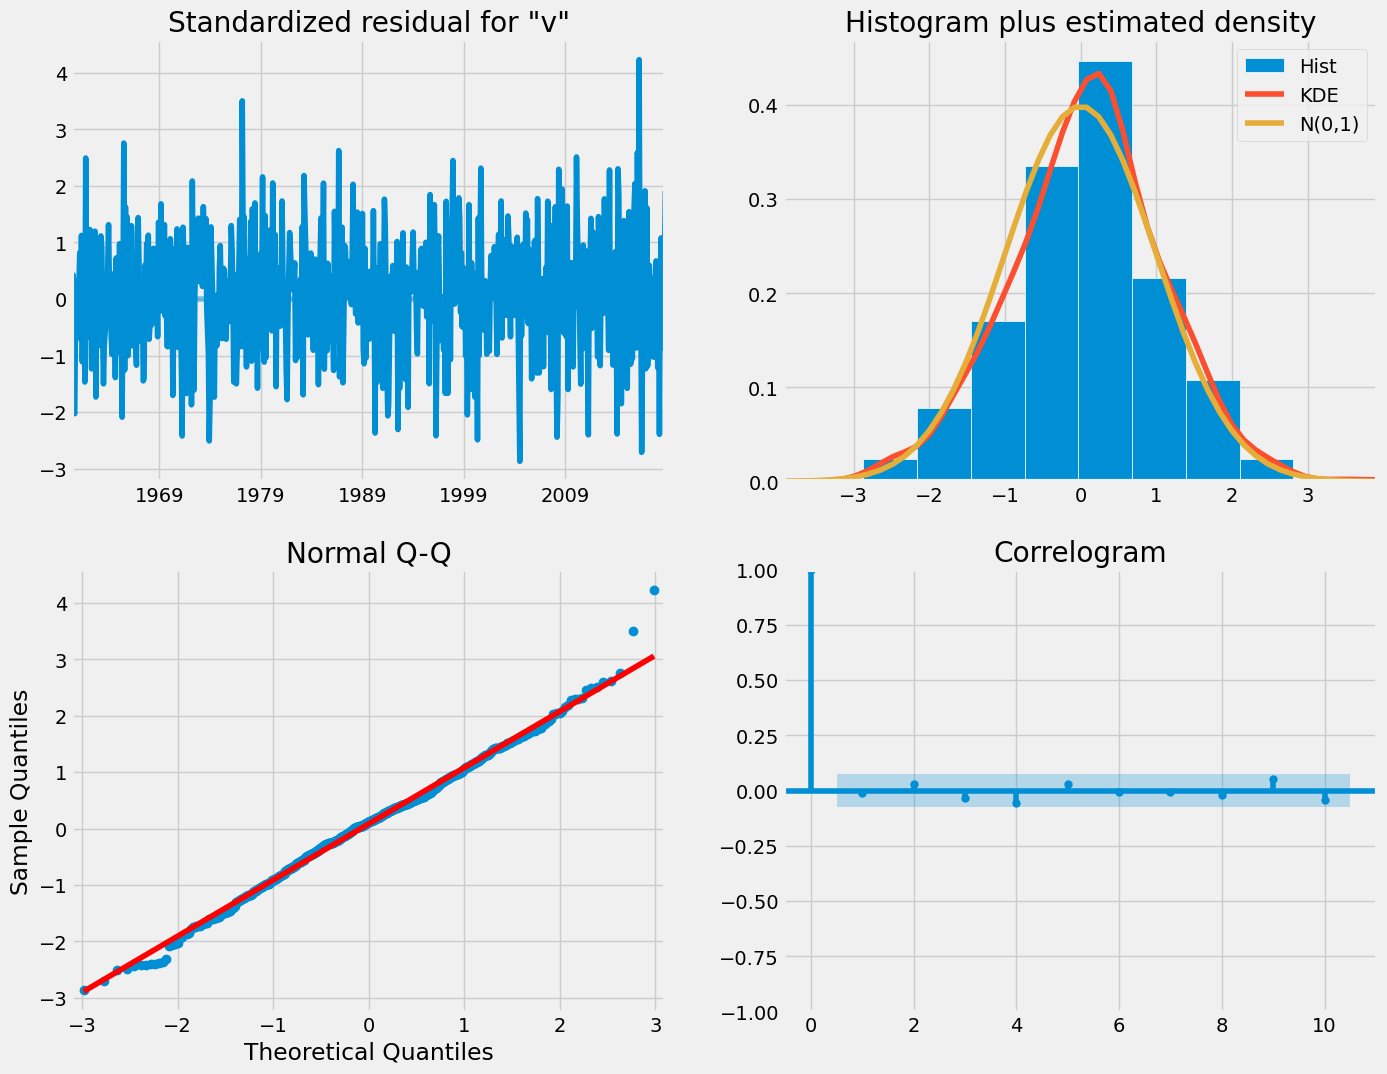

In [21]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

### Прогноз на 30 років

In [22]:
start = sales.index[-1]
end_year = int(str(start)[:4]) + 30
end = pd.to_datetime(str(end_year) + str(start)[4:])

final_predictions = model.get_prediction(start, end)
final_conf_int = final_predictions.conf_int()

Text(0, 0.5, 'Sales')

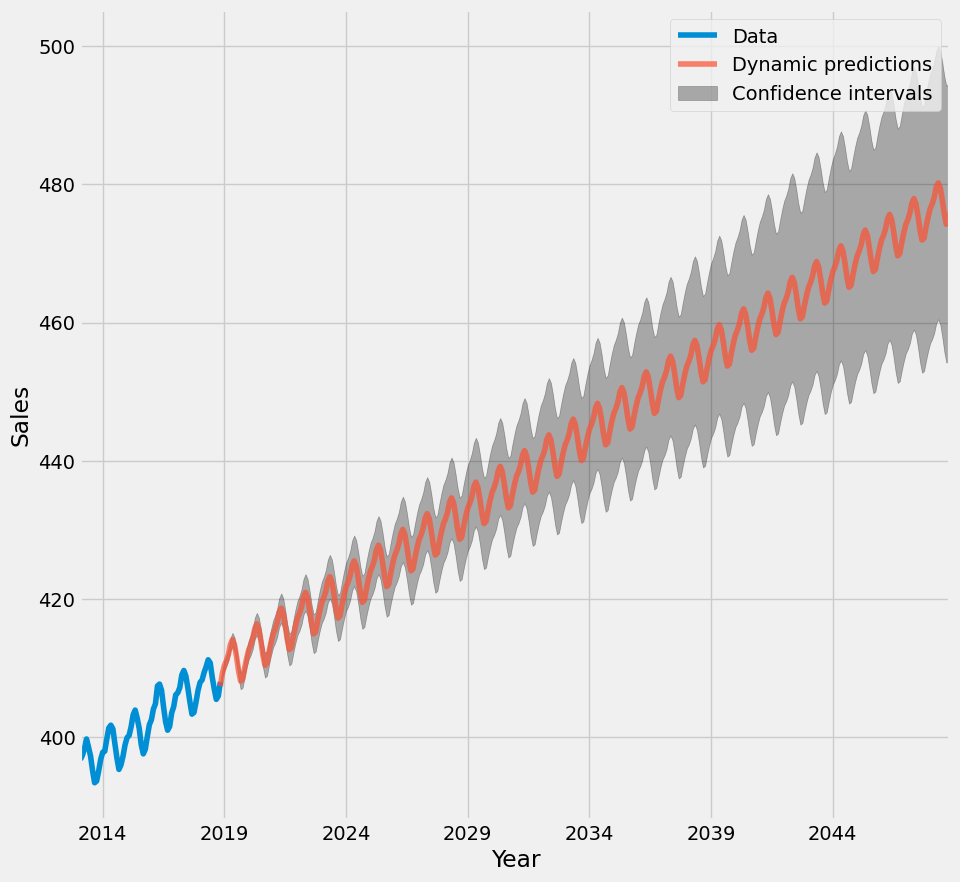

In [23]:
ax = sales[len(sales)-70:].plot()
final_predictions.predicted_mean.plot(alpha=.7)
ax.fill_between(final_conf_int.index, final_conf_int['lower value'], final_conf_int['upper value'], alpha=.3, color='k')

plt.legend(('Data', 'Dynamic predictions', 'Confidence intervals'))
ax.set_xlabel('Year')
ax.set_ylabel('Sales')

In [24]:
index = final_predictions.predicted_mean.index
predictions = final_predictions.predicted_mean.values
lower_conf_int = final_conf_int['lower value'].values
upper_conf_int = final_conf_int['upper value'].values

results = pd.DataFrame(data=np.array([predictions, lower_conf_int, upper_conf_int]).T,
                       index=index,
                       columns=['Sales predictions', 'Lower confidence interval', 'Upper confidence interval'])
results.to_csv('prediction_results.csv')
results.to_excel('prediction_results.xlsx')